<a href="https://colab.research.google.com/github/ENG-KareemSaleh/ml-dl-projects/blob/main/ECG_Heartbeat_Classification_(1D_Conv).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
shayanfazeli_heartbeat_path = kagglehub.dataset_download('shayanfazeli/heartbeat')

print('Data source import complete.')


Data source import complete.


In [ ]:
import numpy as np
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization, LeakyReLU, GlobalAveragePooling1D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report,accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.utils import resample

In [ ]:
df_train = pd.read_csv("/kaggle/input/heartbeat/mitbih_train.csv", header=None)
df_test = pd.read_csv("/kaggle/input/heartbeat/mitbih_test.csv", header=None)

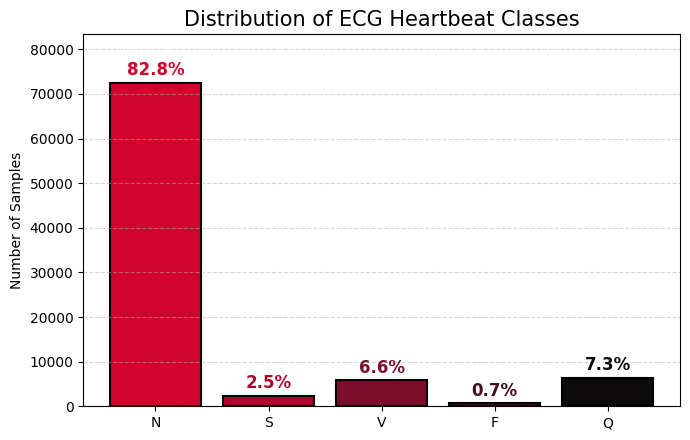

In [ ]:
label_counts = df_train.iloc[:, 187].value_counts().sort_index()
labels = ['N', 'S', 'V', 'F', 'Q']
counts = [label_counts.get(i, 0) for i in range(5)]
total = sum(counts)
percentages = [count / total * 100 for count in counts]

colors = ['#D2042D', '#A8092D', '#7D0D2C', '#450C1C', '#0D0A0B']

plt.figure(figsize=(7, 4.5))
bars = plt.bar(labels, counts, color=colors, edgecolor='black', linewidth=1.5)

for bar, pct, color in zip(bars, percentages, colors):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height + total * 0.01,
             f'{pct:.1f}%', ha='center', va='bottom', color=color,
             fontsize=12, fontweight='bold')

plt.title('Distribution of ECG Heartbeat Classes', fontsize=15)
plt.ylabel('Number of Samples')
plt.ylim(0, max(counts) * 1.15)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

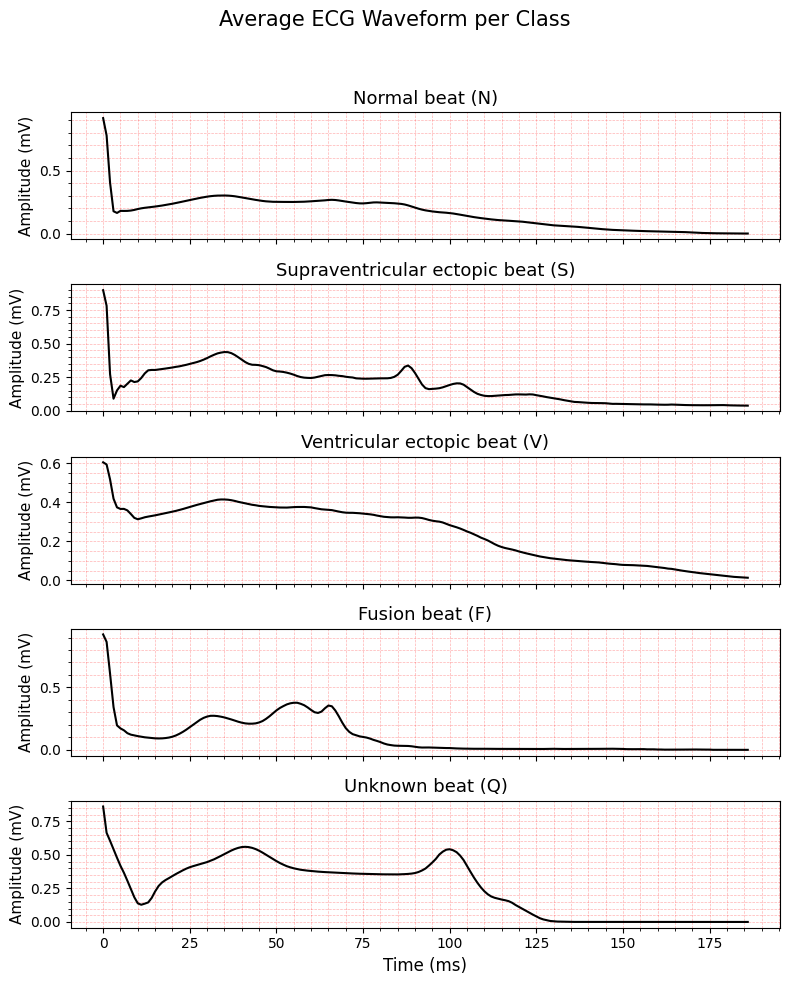

In [ ]:
signal_cols = df_train.columns[:187]
df_signals = df_train[signal_cols]
df_labels = df_train[187]

grouped_classes = df_signals.groupby(df_labels).mean()

conditions = {
    0: "Normal beat (N)",
    1: "Supraventricular ectopic beat (S)",
    2: "Ventricular ectopic beat (V)",
    3: "Fusion beat (F)",
    4: "Unknown beat (Q)"
}

fig, axes = plt.subplots(5, 1, figsize=(8, 10), sharex=True)

for i in range(5):
    signal = grouped_classes.loc[i].values
    ax = axes[i]
    ax.plot(signal, color='black', linewidth=1.5)
    ax.set_title(conditions[i], fontsize=13)
    ax.set_ylabel("Amplitude (mV)", fontsize=11)
    ax.grid(which='both', linestyle='--', linewidth=0.5, color='red', alpha=0.3)
    ax.minorticks_on()

axes[-1].set_xlabel("Time (ms)", fontsize=12)

fig.suptitle("Average ECG Waveform per Class", fontsize=15)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

In [ ]:
X_train = df_train.iloc[:, :187].values
y_train = df_train.iloc[:, 187].values.astype(int)

X_test = df_test.iloc[:, :187].values
y_test = df_test.iloc[:, 187].values.astype(int)


In [ ]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [ ]:
df_bal = pd.DataFrame(X_train_scaled)
df_bal['label'] = y_train

max_count = df_bal['label'].value_counts().max()
df_upsampled = pd.concat([
    resample(df_bal[df_bal['label'] == i], replace=True, n_samples=max_count, random_state=42)
    for i in range(5)
])

df_upsampled = df_upsampled.sample(frac=1, random_state=42)

X_bal = df_upsampled.drop('label', axis=1).values
y_bal = df_upsampled['label'].values.astype(int)

# Reshape for Conv1D
X_bal_cnn = X_bal.reshape(-1, 187, 1)
X_test_cnn = X_test_scaled.reshape(-1, 187, 1)

# Split for validation
X_train_cnn, X_val_cnn, y_train_cnn, y_val_cnn = train_test_split(
    X_bal_cnn, y_bal, test_size=0.2, stratify=y_bal, random_state=42
)


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Dropout, Flatten, Dense, BatchNormalization, LeakyReLU
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

# Build CNN model
model = Sequential([
    Conv1D(32, 5, padding='same', input_shape=(187,1)),
    BatchNormalization(), LeakyReLU(0.3), MaxPooling1D(2), Dropout(0.3),

    Conv1D(64, 5, padding='same'),
    BatchNormalization(), LeakyReLU(0.3), MaxPooling1D(2), Dropout(0.3),

    Conv1D(128, 5, padding='same'),
    BatchNormalization(), LeakyReLU(0.3), MaxPooling1D(2), Dropout(0.3),

    Conv1D(256, 5, padding='same'),
    BatchNormalization(), LeakyReLU(0.3), MaxPooling1D(2), Dropout(0.3),

    Conv1D(512, 5, padding='same'),
    BatchNormalization(), LeakyReLU(0.3), MaxPooling1D(2), Dropout(0.4),

    Conv1D(512, 5, padding='same'),
    BatchNormalization(), LeakyReLU(0.3), MaxPooling1D(2), Dropout(0.4),

    Flatten(),
    Dense(1024), BatchNormalization(), LeakyReLU(0.3), Dropout(0.5),
    Dense(512), BatchNormalization(), LeakyReLU(0.3), Dropout(0.5),
    Dense(256), BatchNormalization(), LeakyReLU(0.3), Dropout(0.5),
    Dense(128), BatchNormalization(), LeakyReLU(0.3), Dropout(0.5),
    Dense(64), BatchNormalization(), LeakyReLU(0.3), Dropout(0.5),
    Dense(32), BatchNormalization(), LeakyReLU(0.3), Dropout(0.5),
    Dense(5, activation='softmax')
])

# Compile model
model.compile(
    optimizer=Adam(1e-3),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Early stopping and LR scheduling
early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3)

# 🛠️ Manual class weights (adjust these if needed)
class_weights_dict = {
    0: 0.3,  # down-weight class 0 to reduce false negatives in minority classes
    1: 2.0,
    2: 1.0,
    3: 2.5,
    4: 1.0
}

# Train model
model.fit(
    X_train_cnn, y_train_cnn,
    validation_data=(X_val_cnn, y_val_cnn),
    epochs=10,
    batch_size=128,
    callbacks=[early_stop, reduce_lr],
    verbose=1,
    class_weight=class_weights_dict
)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
2265/2265 ━━━━━━━━━━━━━━━━━━━━ 70s 21ms/step - accuracy: 0.6249 - loss: 0.9378 - val_accuracy: 0.8960 - val_loss: 0.3276 - learning_rate: 0.0010
Epoch 2/10
2265/2265 ━━━━━━━━━━━━━━━━━━━━ 55s 15ms/step - accuracy: 0.8631 - loss: 0.2592 - val_accuracy: 0.9286 - val_loss: 0.2284 - learning_rate: 0.0010
Epoch 3/10
2265/2265 ━━━━━━━━━━━━━━━━━━━━ 35s 16ms/step - accuracy: 0.9182 - loss: 0.1716 - val_accuracy: 0.9561 - val_loss: 0.1443 - learning_rate: 0.0010
Epoch 4/10
2265/2265 ━━━━━━━━━━━━━━━━━━━━ 39s 14ms/step - accuracy: 0.9380 - loss: 0.1302 - val_accuracy: 0.9616 - val_loss: 0.1199 - learning_rate: 0.0010
Epoch 5/10
2265/2265 ━━━━━━━━━━━━━━━━━━━━ 41s 14ms/step - accuracy: 0.9472 - loss: 0.1067 - val_accuracy: 0.9682 - val_loss: 0.1062 - learning_rate: 0.0010
Epoch 6/10
2265/2265 ━━━━━━━━━━━━━━━━━━━━ 41s 14ms/step - accuracy: 0.9560 - loss: 0.0894 - val_accuracy: 0.9668 - val_loss: 0.1012 - learning_rate: 0.0010
Epoch 7/10
2265/2265 ━━━━━━━━━━━━━━━━━━━━ 41s 15ms/step - accura

In [ ]:
from xgboost import XGBClassifier

# ----------------------------
# Binary labels
# ----------------------------
y_binary_0 = (y_train == 0).astype(int)
y_binary_1 = (y_train == 1).astype(int)
y_binary_3 = (y_train == 3).astype(int)

# ----------------------------
# Class 0 XGBoost classifier
# ----------------------------
xgb_0 = XGBClassifier(
    n_estimators=200,
    max_depth=4,
    scale_pos_weight=(len(y_binary_0) - y_binary_0.sum()) / y_binary_0.sum(),
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)
xgb_0.fit(X_train_scaled, y_binary_0)

# ----------------------------
# Class 1 XGBoost classifier
# ----------------------------
xgb_1 = XGBClassifier(
    n_estimators=200,
    max_depth=4,
    scale_pos_weight=(len(y_binary_1) - y_binary_1.sum()) / y_binary_1.sum(),
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)
xgb_1.fit(X_train_scaled, y_binary_1)

# ----------------------------
# Class 3 XGBoost classifier (now WITH scale_pos_weight)
# ----------------------------
xgb_3 = XGBClassifier(
    n_estimators=200,
    max_depth=4,
    learning_rate=0.1,
    scale_pos_weight=(len(y_binary_3) - y_binary_3.sum()) / y_binary_3.sum(),
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)
xgb_3.fit(X_train_scaled, y_binary_3)

# ----------------------------
# Predict probabilities
# ----------------------------
y_bin_0 = xgb_0.predict_proba(X_test_scaled)[:, 1]  # Probability of class 0
y_bin_1 = xgb_1.predict_proba(X_test_scaled)[:, 1]  # Probability of class 1
y_bin_3 = xgb_3.predict_proba(X_test_scaled)[:, 1]  # Probability of class 3


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [02:09:00] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [02:09:19] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [02:09:37] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve

# ----------------------------
# CNN predictions
# ----------------------------
y_cnn_proba = model.predict(X_test_cnn, verbose=0)
y_cnn_pred = np.argmax(y_cnn_proba, axis=1)

# ----------------------------
# XGBoost binary classifier probabilities
# ----------------------------
y_bin_0 = xgb_0.predict_proba(X_test_scaled)[:, 1]  # Probability of class 0
y_bin_1 = xgb_1.predict_proba(X_test_scaled)[:, 1]  # Probability of class 1
y_bin_3 = xgb_3.predict_proba(X_test_scaled)[:, 1]  # Probability of class 3

# ----------------------------
# Class 1 - ROC Curve and Threshold
# ----------------------------
y_true_binary_1 = (y_test == 1).astype(int)

fpr_1, tpr_1, thresholds_1 = roc_curve(y_true_binary_1, y_bin_1)
target_recall_1 = 0.90
index_1 = np.argmax(tpr_1 >= target_recall_1)

if index_1 < len(thresholds_1):
    best_threshold_1 = thresholds_1[index_1]
else:
    best_threshold_1 = thresholds_1[-1]  # fallback

print(f"\nBest threshold for class 1 with recall ≥ {target_recall_1}: {best_threshold_1:.4f}")

# Optional: Diagnostic metrics for class 1
y_pred_binary_1 = (y_bin_1 > 0.5).astype(int)
print("\nXGBoost Binary Classifier for Class 1 vs Others:")
print(classification_report(y_true_binary_1, y_pred_binary_1, digits=4))
print("Confusion Matrix:")
print(confusion_matrix(y_true_binary_1, y_pred_binary_1))
print("ROC AUC Score (Class 1):", round(roc_auc_score(y_true_binary_1, y_bin_1), 4))

# ----------------------------
# Class 3 - ROC Curve and Threshold
# ----------------------------
y_true_binary_3 = (y_test == 3).astype(int)

fpr_3, tpr_3, thresholds_3 = roc_curve(y_true_binary_3, y_bin_3)
target_recall_3 = 0.90
index_3 = np.argmax(tpr_3 >= target_recall_3)

if index_3 < len(thresholds_3):
    best_threshold_3 = thresholds_3[index_3]
else:
    best_threshold_3 = thresholds_3[-1]

print(f"\nBest threshold for class 3 with recall ≥ {target_recall_3}: {best_threshold_3:.4f}")



Best threshold for class 1 with recall ≥ 0.9: 0.0626

XGBoost Binary Classifier for Class 1 vs Others:
              precision    recall  f1-score   support

           0     0.9946    0.9914    0.9930     21336
           1     0.7067    0.7932    0.7475       556

    accuracy                         0.9864     21892
   macro avg     0.8507    0.8923    0.8702     21892
weighted avg     0.9873    0.9864    0.9868     21892

Confusion Matrix:
[[21153   183]
 [  115   441]]
ROC AUC Score (Class 1): 0.9605

Best threshold for class 3 with recall ≥ 0.9: 0.2426


In [ ]:
final_preds = []

for i in range(len(y_cnn_pred)):
    cnn_class = y_cnn_pred[i]
    cnn_conf = y_cnn_proba[i][cnn_class]

    prob_class_1 = y_cnn_proba[i][1]
    prob_class_3 = y_cnn_proba[i][3]

    bin_prob_0 = y_bin_0[i]
    bin_prob_1 = y_bin_1[i]
    bin_prob_3 = y_bin_3[i]

    # --- Override to Class 1 if both classifiers agree ---
    if cnn_class != 1 and prob_class_1 > 0.45 and bin_prob_1 > best_threshold_1:
        final_preds.append(1)

    # --- Override to Class 3 if both classifiers agree ---
    elif cnn_class != 3 and prob_class_3 > 0.4 and bin_prob_3 > best_threshold_3:
        final_preds.append(3)

    # --- Otherwise, keep original CNN prediction ---
    else:
        final_preds.append(cnn_class)

final_preds = np.array(final_preds)


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

print("Hybrid Ensemble with Class 0, Class 1 & Class 3 Reinforcement (Updated):")
print(classification_report(y_test, final_preds))
print("Confusion Matrix:")
print(confusion_matrix(y_test, final_preds))


Hybrid Ensemble with Class 0, Class 1 & Class 3 Reinforcement (Updated):
              precision    recall  f1-score   support

           0       1.00      0.91      0.95     18118
           1       0.38      0.92      0.53       556
           2       0.89      0.95      0.92      1448
           3       0.21      0.93      0.34       162
           4       0.96      0.99      0.97      1608

    accuracy                           0.92     21892
   macro avg       0.69      0.94      0.74     21892
weighted avg       0.97      0.92      0.94     21892

Confusion Matrix:
[[16543   828   165   511    71]
 [   31   510     7     6     2]
 [   11    10  1377    48     2]
 [    3     4     4   151     0]
 [    3     3     1     2  1599]]
